In [1]:
%matplotlib notebook

from __future__ import division
import math
import sys
import os
import csv
import sqlite3
import pandas
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

sys.path.append('.')
import scripts2d.utils as u
from wde.estimator import WaveletDensityEstimator
from wde.simple_estimator import SimpleWaveletDensityEstimator
from wde.common import np_mult
from wde.thresholding import soft_threshold, hard_threshold, block_threshold


In [2]:
DBNAME = 'data/%s/db4/data.db'
CSVNAME = 'data/%s/db4/all-ise.csv'

def create_table(conn):
    sql = """
    CREATE TABLE IF NOT EXISTS results (
     fname varchar(256) NOT NULL,
     n integer NOT NULL,
     j0 integer NOT NULL,
     j1 integer NOT NULL,
     k integer NOT NULL,
     ise real NOT NULL,
     etime real NOT NULL
     )
    """
    conn.execute(sql)
    print 'results created'

def connect(dist_code):
    dbname = DBNAME % dist_code
    if not os.path.isfile(dbname):
        conn = sqlite3.connect(dbname)
        create_table(conn)
    else:
        conn = sqlite3.connect(dbname)
    return conn

def read_rows(fcsv):
    for row in fcsv:
        if len(row) == 0 or len(row[0]) == 0:
            continue
        try:
            # fname, dist_code, wave_code, n, j0, j1, k, ise, elapsed_time
            yield row[0], int(row[3]), int(row[4]), int(row[5]), int(row[6]), float(row[7]), float(row[8])
        except:
            print 'E:',fcsv.line_num, len(row)

def load_data(dist_code):
    csvname = CSVNAME % dist_code
    with open(csvname, 'r') as f:
        fcsv = csv.reader(f)
        with connect(dist_code) as conn:
            conn.execute('delete from results')
            headers = next(fcsv)
            print headers
            for fname, n, j0, j1, k, ise, etime in read_rows(fcsv):
                try:
                    conn.execute('insert into results (fname, n, j0, j1, k, ise, etime) values (?,?,?,?,?,?,?)', (fname, n, j0, j1, k, ise, etime))
                except sqlite3.Error as e:
                    print e
                    print fname, n
                    raise
    print 'Done'

def exec_gen(conn, sql, args=()):
    cur = conn.execute(sql, args)
    row = cur.fetchone()
    while row is not None:
        yield row
        row = cur.fetchone()

In [3]:
def contour_plot_it(dists, data, title='Contour', fname=None):
    fig = plt.figure(figsize=(4, 4), dpi=144)
    X = np.linspace(0.0,1.0, num=75)
    Y = np.linspace(0.0,1.0, num=75)
    XX, YY = np.meshgrid(X, Y)
    if type(dists) is not tuple:
        dists=(dists,)
    minz, maxz = float('inf'), float('-inf')
    Zs = []
    for dist in dists:
        Z = dist.pdf((XX, YY))
        Zs.append(Z)
        minz = min(minz, Z.min())
        maxz = max(maxz, Z.max())
    levels = np.linspace(minz, maxz, num=10)
    cmap = cm.get_cmap('BuGn')
    if minz == 0:
        levels = np.linspace(minz + (maxz-minz)/100, maxz, num=10)
        cmap.set_under("magenta")
    linestyles = enumerate(['solid','dashed', 'dashdot', 'dotted'])
    alphas = enumerate([0.4,1.0,0.2,0.2])
    for dist, Z in zip(dists, Zs):
        linestyle = next(linestyles)[1]
        cs = plt.contour(XX, YY, Z, alpha=(next(alphas)[1]), linestyles=linestyle, levels=levels, extend='min', cmap=cmap)
        if linestyle == 'dashed':
            plt.clabel(cs, inline=1, fontsize=10)
    plt.scatter(data[:,0], data[:,1], s=1, alpha=0.4)
    #avg = data.mean(axis=0)
    #plt.scatter(avg[0],avg[1], s=10, marker='+', color='r')
    plt.title(title)
    if fname is not None:
        plt.savefig('data/%s' % fname, pad_inches=0.0, orientation='portrait', frameon=False)
    plt.show()
    
def plot_it(dist, fname=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.linspace(0.0,1.0, num=75)
    Y = np.linspace(0.0,1.0, num=75)
    XX, YY = np.meshgrid(X, Y)
    Z = dist.pdf((XX, YY))
    surf = ax.plot_surface(XX, YY, Z, edgecolors='k', linewidth=0.5, cmap=cm.get_cmap('BuGn'))
    #ax.set_zlim(0, 5)
    if fname is not None:
        plt.savefig('data/%s' % fname, pad_inches=0.0, orientation='portrait', frameon=False)
    plt.show()


In [4]:
def best_for(dist_code):
    sql = "select distinct j0, j1 from results where n = ? order by j0, j1"
    sql2 = "select distinct k from results where n = ? and j0 = ? and j1 = ? order by k"
    sql3 = "select ise from results where n = ? and j0 = ? and j1 = ? and k = ? order by ise"
    s = """\\bigstrut\\\\
		\\hline
		{n:d}   & {j0:d}  & {j1:d}    & {ks:s} &{k:d} & {mise:f}
        """
    with connect(dist_code) as conn:
        data = {}
        for n in [500, 1000, 2000, 5000]:
            params = []
            for row in exec_gen(conn, sql, (n,)):
                j0, j1 = row
                ks = [vs[0] for vs in list(exec_gen(conn, sql2, (n, j0, j1)))]
                kmise = []
                for k in ks:
                    ises = [vs[0] for vs in list(exec_gen(conn, sql3, (n, j0, j1, k)))]
                    median = ises[len(ises)//2]
                    kmise.append((k, median))
                    print n, j0, j1, k, median, 1.0/math.sqrt(n)
                kmise = sorted(kmise, key = (lambda p: p[1]))
                k, kmise = kmise[0][0], kmise[0][1]
                #print n,(j0, j1, ks, k), kmise
                #params.append(((j0, j1, ks, k), kmise))
            #params = sorted(params, key=(lambda p: p[1]))
            #print params
            #bb = params[0]
            #print s.format(n=n, j0=bb[0][0], j1=bb[0][1], ks=str(bb[0][2])[1:-2], k=bb[0][3], mise=bb[1])
#best_for('mult')

In [5]:
def plot_n_vs_mise():
    data = []
    with connect() as conn:
        sql = "select n, min(ise) from results group by n"
        for row in exec_gen(conn, sql):
            data.append(row)
    data = np.array(data)
    plt.plot(data[:,0], data[:,1], 'b:')
    plt.title('Sample size vs MISE - Beta')
    plt.xlabel('n')
    plt.ylabel('MISE')
    plt.show()

def get_best_for_n():
    with connect() as conn:
        sql = "select n, j0, j1, k, avg(ise) as mise from results group by n, j0, j1, k"
        data = {}
        for row in exec_gen(conn, sql):
            n, j0, j1, k, mise = row
            if n not in data:
                data[n] = []
            if j1 < j0: j1 = None
            data[n].append((j0, j1, k, mise))
        nn = data.keys()
        nn.sort()
        print 'n, j0, j1, k, MISE'
        for n in nn:
            data[n].sort(key=(lambda tt: tt[3]))
            print n, 'j0=%d, j1=%d, k=%d' % data[n][0][0:3]

def get_best_params_for_n():
    data = {}
    with connect() as conn:
        sql = "select n, j0, j1, k, ise from results order by n, j0, j1, k"
        curparams = None
        curdata = []
        summary = []
        # calculate robust MISE from data for n, j0, j1, k
        for row in exec_gen(conn, sql):
            params = row[0:4]
            ise = row[4]
            if curparams == params:
                curdata.append(ise)
            else:
                if curparams is not None:
                    rmise = np.median(np.array(curdata))
                    summary.append((curparams, rmise))
                curdata = [ise]
                curparams = params
        if curparams is not None:
            rmise = np.median(np.array(curdata))
            summary.append((curparams, rmise))
        # now pick best j0, j1, k for each n
        min_rmise = {}
        curdata = []
        for params, rmise in summary:
            n, j0, j1, k = params
            if n in min_rmise:
                _, val = min_rmise[n]
                if rmise < val:
                    min_rmise[n] = ((j0, j1, k), rmise)
            else:
                min_rmise[n] = ((j0, j1, k), rmise)
        nn = min_rmise.keys()
        nn.sort()
        mises = []
        plt.figure()
        for n in nn:
            params, mise = min_rmise[n]
            #print n, '(j0,j1,k)=', params,'MISE=', mise
            mises.append(mise)
            plt.text(n if n<=4000 else n - 1350, mise + (0.006 if n<=4000 else -0.008), str(params))
        plt.scatter(nn, mises)
        plt.xlabel('n')
        plt.ylabel('MISE')
        plt.title('Best j0, j1, k per sample size (Bivariate Beta)')
        plt.show()

def average_after_best_per_sample():
    pass

def plot_example(n, **kwargs):
    dist = u.dist_from_code('mult')
    data = dist.rvs(n)
    plot_it(dist, 'true-3D.eps')
    wde = WaveletDensityEstimator('sym8', **kwargs)
    wde.fit(data)
    XX, YY = u.mise_mesh()
    Z = dist.pdf((XX, YY))
    ise = u.calc_ise(wde.pdf, Z)
    print 'ISE>>', ise
    #contour_plot_it(wde, data) #, fname='mult-nothreshold.j0={j0:d}.j1={j1:d}.k={k:d}.eps'.format(**kwargs))
    #return
    #plt.figure()
    #plt.hist(cs, bins=40, normed=True)
    #plt.show()
    #block_thresholding_calc(wde, ise, Z)
    ise1, th_v = soft_threshold_calc(wde, ise, Z)
    ise2, th_nn = block_thresholding_calc(wde, ise, Z)
    if ise1 < ise2:
        wde.thresholding = soft_threshold(th_v)
        wde.pdf = wde.calc_pdf()
        title = 'Soft threshold = %f' % th_v
    else:
        title = 'Block threshold %d' % th_nn
    print title
    plot_it(wde, 'esti-3D.eps')
    #wde.thresholding = hard_block_threshold(th_v / math.sqrt(th_nn))
    #wde.pdf = wde.calc_pdf()
    #ise3 = u.calc_ise(wde.pdf, Z)
    #print 'ISE 3>>', ise3
    return

def block_thresholding_calc(wde, ise, Z):
    cs = wde.get_nums()
    nn0 = 1
    nn1 = max(cs)
    err = 1
    best_ise = ise
    best_nn = nn1
    best_i = 7
    print 'MAX N', nn1
    while nn1 > nn0 + 1:
        best_i = 4
        for i in range(9):
            nn_i = nn0 + (nn1 - nn0) * i // 8
            wde.thresholding = block_threshold(nn_i)
            wde.pdf = wde.calc_pdf()
            new_ise = u.calc_ise(wde.pdf, Z)
            if new_ise < best_ise:
                best_ise = new_ise
                best_nn = nn_i
                best_i = i
        print '(%d,%d)' % (nn0, nn1), best_nn, '(%d)' % best_i, '>', best_ise, err
        i0 = max(best_i - 1, 0)
        i1 = min(best_i + 1, 8)
        nn0, nn1 = nn0 + (nn1 - nn0) * i0 // 8, nn0 + (nn1 - nn0) * i1 // 8
    wde.thresholding = block_threshold(best_nn) # / (math.sqrt(kwargs['j1']-kwargs['j0']+1) / math.sqrt(n)))
    wde.pdf = wde.calc_pdf()
    new_ise = u.calc_ise(wde.pdf, Z)            
    print 'NEW ISE>>', new_ise
    return (new_ise, best_nn)

def soft_threshold_calc(wde, ise, Z):
    # hard-block thresholding calculation
    tt0 = 0
    tt1 = 1
    err = 1
    best_ise = ise
    best_tt = tt1
    best_i = 7
    while err > 0.000001:
        err = 0
        for i in range(8):
            tt_i = tt0 + (tt1 - tt0) * i / 7
            wde.thresholding = soft_threshold(tt_i) # / (math.sqrt(kwargs['j1']-kwargs['j0']+1) / math.sqrt(n)))
            wde.pdf = wde.calc_pdf()
            new_ise = u.calc_ise(wde.pdf, Z)
            if new_ise < best_ise:
                err = best_ise - new_ise
                best_ise = new_ise
                best_tt = tt_i
                best_i = i
        print '(%f,%f)' % (tt0, tt1), best_tt, '(%d)' % best_i, '>', best_ise, err
        i0 = max(best_i - 2, 0)
        i1 = min(best_i + 2, 7)
        tt0, tt1 = tt0 + (tt1 - tt0) * i0 / 7, tt0 + (tt1 - tt0) * i1 / 7
    wde.thresholding = soft_threshold(best_tt) # / (math.sqrt(kwargs['j1']-kwargs['j0']+1) / math.sqrt(n)))
    wde.pdf = wde.calc_pdf()
    new_ise = u.calc_ise(wde.pdf, Z)            
    print 'NEW ISE>>', new_ise
    return (new_ise, best_tt)

def save(code):
    dist = u.dist_from_code(code)
    plot_it(dist, fname='true-%s.eps' % code)


#load_data()
#get_best_params_for_n()
#get_best_for_n()
#plot_n_vs_mise()
#plot_example(500, j0=0, j1=2, k=4)
#save('beta')

In [6]:
def make_table():
    s = """\\bigstrut\\\\
		\\hline
		{n:d}   & {j0:d}  & {j1:d}    & {ks:s} &{k:d} & {mise:f}
        """
    data = []
    with connect() as conn:
        sql = "select n, j0, j1, k, avg(ise) as mise from results group by n, j0, j1, k"
        n = None
        ps = None
        for row in exec_gen(conn, sql):
            if n != row[0]:
                if n is not None:
                    data.append(dict(n=ps[0], j0=ps[1], j1=ps[2], k=ps[3], ks=ks, mise=ps[4]))
                n = row[0]
                ps = row
                ks = []
            if row[4] < ps[4]:
                ps = row
            if row[3] not in ks:
                ks.append(row[3])                
    data.append(dict(n=ps[0], j0=ps[1], j1=ps[2], k=ps[3], ks=ks, mise=ps[4]))
    print data
    with open('data/table-beta.txt', 'w') as f:
        for row in data:
            f.write(s.format(**row))
    print 'Done'
    
#make_table()

In [7]:
def vals():
    data = []
    with connect() as conn:
        sql = "select n, j0, j1, avg(ise) as mise from results where k = 1 group by n, j0, j1"
        n = None
        ps = None
        for row in exec_gen(conn, sql):
            print row
    print 'Done'
    
#vals()

In [8]:
def p2(n, **kwargs):
    dist = u.dist_from_code('beta')
    resp = {}
    print 'N = %d' % n
    for wave in ['db2','sym2','db4','sym4','db6','sym6','db8','sym8']:
        nums = []
        N = 25
        for i in range(N):
            data = dist.rvs(n)
            #plot_it(dist)
            wde = WaveletDensityEstimator(wave, **kwargs)
            wde.fit(data)
            XX, YY = u.mise_mesh()
            Z = dist.pdf((XX, YY))
            ise = u.calc_ise(wde.pdf, Z)
            nums.append(ise)
            #print wave, i, ise
        nums = np.array(nums)
        print wave, nums.mean(), nums.std()
    #plot_it(wde)

#p2(500, j0=2, j1=0)
#p2(1000, j0=2, j1=0)

In [9]:
def p3(n, **kwargs):
    dist = u.dist_from_code('beta')
    wde = WaveletDensityEstimator('db10', **kwargs)
    points = []
    ix_from, ix_to = (2 * n) // 3, (n * 3) // 2 
    print 'from %d, to %d' % (ix_from, ix_to)
    for i in range(ix_from, ix_to, 2):
        data = dist.rvs(n)
        wde.fit(data)
        XX, YY = u.mise_mesh()
        Z = dist.pdf((XX, YY))
        ise = u.calc_ise(wde.pdf, Z)
        points.append(dict(n=i, ise=ise))
    df = pandas.DataFrame(points)
    df.to_csv('data/ise.csv')
    plt.figure()
    plt.scatter(df['n'], df['ise'], s=2)
    plt.show()
#p3(500, j0=0, j1=1)

In [10]:
wde_glob = None
def p5(n, wv, **kwargs):
    global wde_glob
    dist = u.dist_from_code('mix2')
    for n in [500,1000,2000]:
        for j0 in [2,3,4]:
            s = 0.0
            for i in range(10):
                data = dist.rvs(n)
                wde = WaveletDensityEstimator(wv, j0=j0, j1=j0-1)
                #print data.mean(axis=0)
                wde.fit(data)
                XX, YY = u.mise_mesh()
                Z = dist.pdf((XX, YY))
                ise = u.calc_ise(wde.pdf, Z)
                s += ise
            print n, j0, s/10.0
    #contour_plot_it((dist,wde,), data, 'Beta & WDE - n=%d, wv=%s, j0=%d, j1=%d' % (n, wv, kwargs['j0'], kwargs['j1']))
    wde_glob = wde
#p5(2000, 'db6', j0=0, j1=2)

ISE: 0.302260500497


<IPython.core.display.Javascript object>


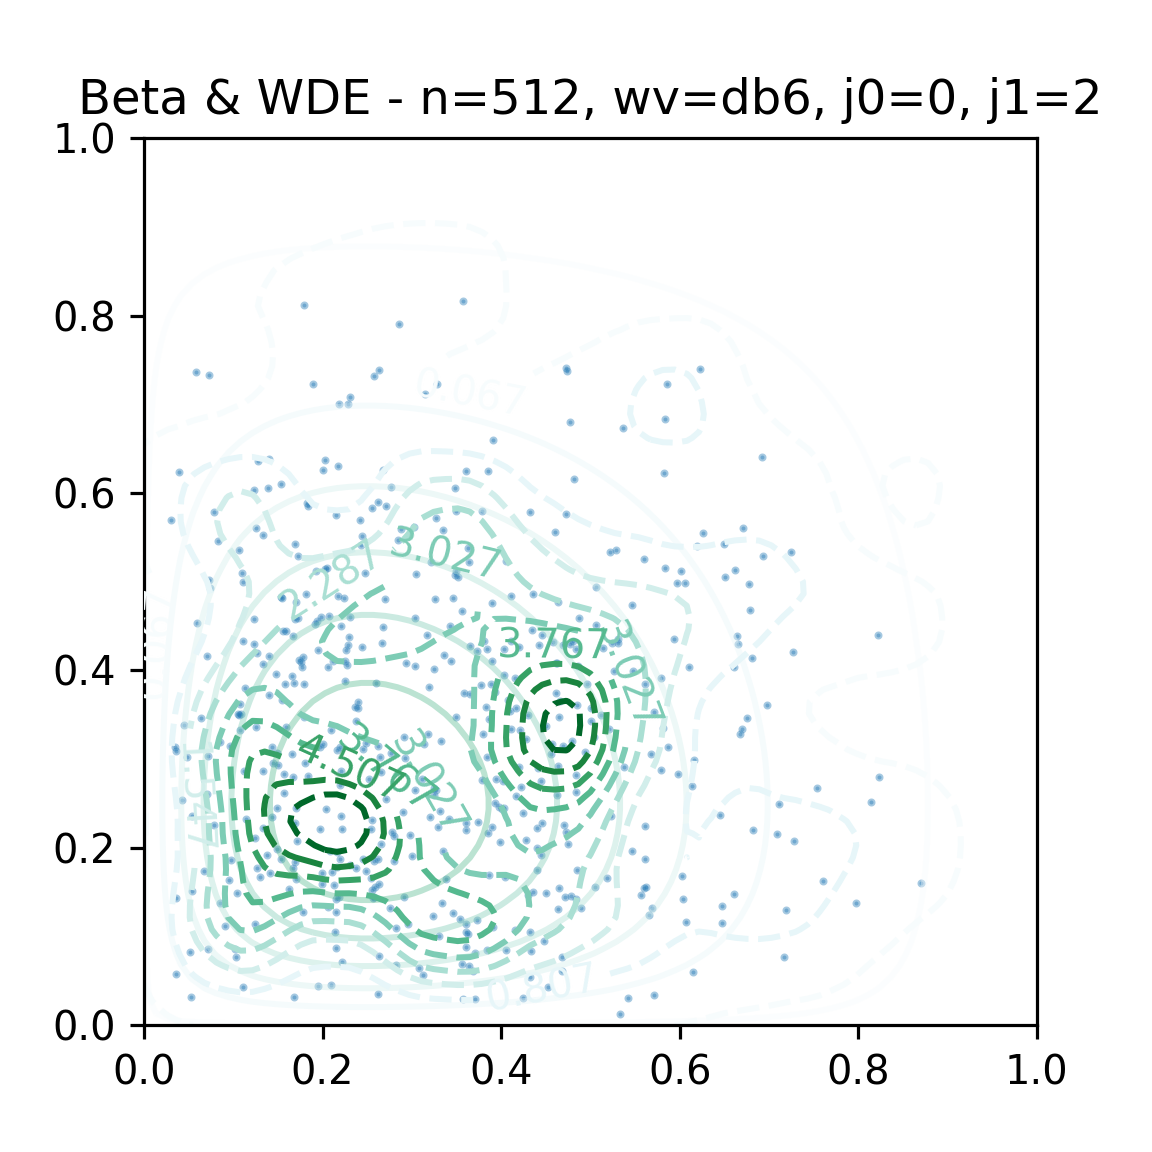

In [11]:
wde_glob = None
def p11(n, wv, **kwargs):
    global wde_glob
    dist = u.dist_from_code('beta')
    data = dist.rvs(n)
    wde = WaveletDensityEstimator(wv, **kwargs)
    #print data.mean(axis=0)
    wde.fit(data)
    XX, YY = u.mise_mesh()
    Z = dist.pdf((XX, YY))
    ise = u.calc_ise(wde.pdf, Z)
    print 'ISE:', ise
    contour_plot_it((dist,wde,), data, 'Beta & WDE - n=%d, wv=%s, j0=%d, j1=%d' % (n, wv, kwargs['j0'], kwargs['j1']))
    #plot_it(wde)
    wde_glob = wde
p11(512, 'db6', j0=0, j1=2)

In [12]:
def error_func(params, ns, ises):
    a, b1, b2, k = params
    ys = (ns ** (-k)) * b1 + (ns ** (-1.0)) * b2 + a
    residuals = ys - ises
    return (residuals * residuals).mean()

def regression_for():
    points = pandas.read_csv('data/ise.csv')
    a = points['ise'].mean()
    k = 0.8
    b = (points['ise'].sum() - points['n'].size * a) / (points['n'] ** (-k)).sum()
    ini_guess = (a, b, b, k)
    reqs = [
        # minx < load_a < maxx
        {
            'type': 'ineq',
            'fun': lambda params: params[0] # a > 0
        },
        {
            'type': 'ineq',
            'fun': lambda params: params[1] # b1 > 0
        },
        {
            'type': 'ineq',
            'fun': lambda params: params[2] # b2 > 0
        },
        {
            'type': 'ineq',
            'fun': lambda params: params[3] # k > 0
        }
    ]
    result = minimize(
        error_func,
        ini_guess,
        args=(points['n'], points['ise']),
        constraints=reqs,
        method='COBYLA',
        options=dict(maxiter=10000))
    if result.success:
        print 'err>', result.fun
        print 'solution>', result.x
    else:
        print 'failure>', result.message
    a, b1, b2, k = result.x
    ys = (points['n'] ** (-k)) * b1 + (points['n'] ** (-1.0)) * b2 + a
    plt.figure()
    plt.scatter(points['n'], points['ise'], s=1)
    plt.plot(points['n'], ys, 'k:')
    plt.show()
    
#regression_for()

In [13]:
# single coefficient
def plot_wave_fun(dist, wde, jpow, qx, zs):
    wfun = wde.wave_funs[qx]
    supp = wfun.support + zs
    ff = np_mult(supp[1,:] - supp[0,:])
    X = np.linspace(supp[0,0], supp[1,0], num=256)
    Y = np.linspace(supp[0,1], supp[1,1], num=256)
    XX, YY = np.meshgrid(X, Y) # X,Y
    cmap = cm.get_cmap('BuGn')
    Z = wfun(jpow, np.array(zs), (XX, YY))
    nn = reduce(lambda x, y: (x-1) * (y-1), Z.shape)
    ff3 = (Z*Z).sum()/(nn) * ff
    print math.sqrt(ff3)
    Z2 = np.sqrt(dist.pdf((XX, YY)))
    print (Z * Z2).sum()/(nn) * ff / math.sqrt(ff3)
    return
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(XX, YY, Z, edgecolors='k', linewidth=0.5, cmap=cmap)
    plt.show()
    
def p7(n, wv, **kwargs):
    global wde_glob
    dist = u.dist_from_code('beta')
    wde = WaveletDensityEstimator(wv, **kwargs)
    #print data.mean(axis=0)
    wde.calc_wavefuns(2)
    jpow = 2 ** kwargs['j0']
    plot_wave_fun(dist, wde, jpow, (0,1), (0,0))
    for i in range(20):
        data = dist.rvs(n)
        wde.fit(data)
        print i, ',', wde.coeffs[0][(0,1)][(0,0)]
    
#p7(2000, 'db6', j0=0, j1=1)